*Python Machine Learning 2nd Edition* by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2017

Code Repository: https://github.com/rasbt/python-machine-learning-book-2nd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 15 - Classifying Images with Deep Convolutional Neural Networks

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka & Vahid Mirjalili' -d -p numpy,scipy,tensorflow

Sebastian Raschka & Vahid Mirjalili 2017-09-09 

numpy 1.12.1
scipy 0.19.1
tensorflow 1.3.0


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see*: https://github.com/rasbt/watermark.

### Overview

- [Building blocks of convolutional neural networks](#Building-blocks-of-convolutional-neural-networks)
  - [Understanding CNNs and learning feature hierarchies](#Understanding-CNNs-and-learning-feature-hierarchies)
  - [Performing discrete convolutions](#Performing-discrete-convolutions)
    - [Performing a discrete convolution in one dimension](#Performing-a-discrete-convolution-in-one-dimension)
    - [The effect of zero-padding in convolution](#The-effect-of-zero-padding-in-convolution)
    - [Determining the size of the convolution output](#Determining-the-size-of-the-convolution-output)
    - [Performing a discrete convolution in 2D](#Performing-a-discrete-convolution-in-2D)
    - [Sub-sampling](#Sub-sampling)
  - [Putting everything together to build a CNN](#Putting-everything-together-to-build-a-CNN)
    - [The multilayer CNN architecture](#The-multilayer-CNN-architecture)
    - [Loading and preprocessing the data](#Loading-and-preprocessing-the-data)
    - [Implementing a CNN in TensorFlow low-level API](#Implementing-a-CNN-in-TensorFlow-low-level-API)
    - [Implementing a CNN in the TensorFlow layers API](#Implementing-a-CNN-in-the-TensorFlow-layers-API)

In [2]:
from IPython.display import Image
%matplotlib inline

In [3]:
# This is for Python 2.7 compatibility
from __future__ import print_function

# Building blocks of convolutional neural networks 

## Understanding CNNs and learning feature hierarchies

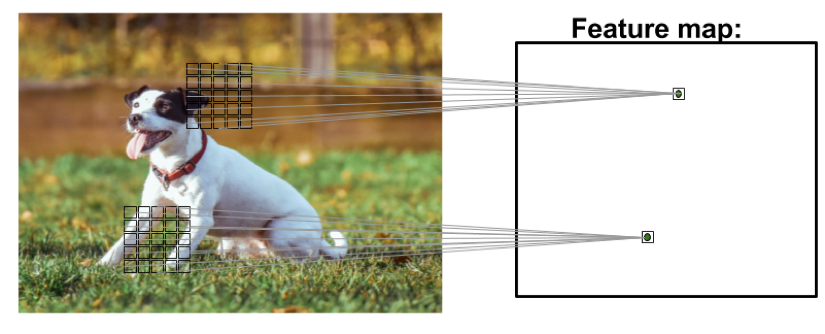

In [4]:
Image(filename='images/15_01.png', width=700) 

## Performing discrete convolutions  

###  Performing a discrete convolution in one dimension

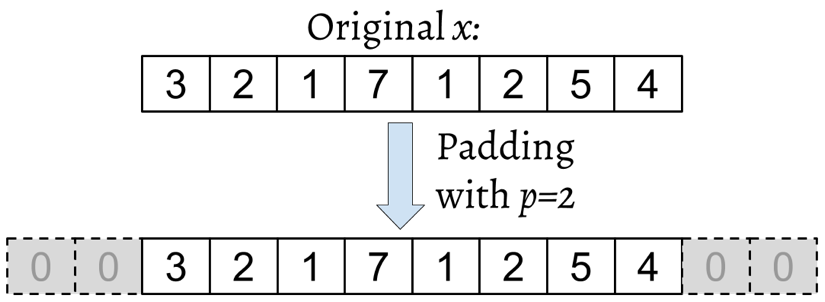

In [5]:
Image(filename='images/15_02.png', width=700) 

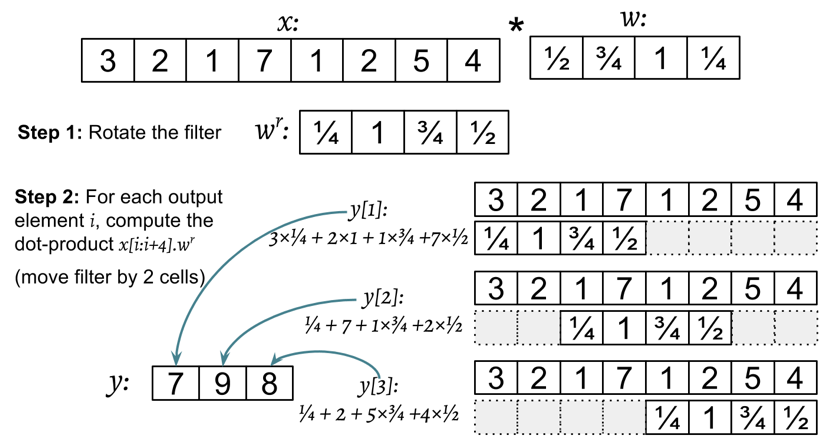

In [6]:
Image(filename='images/15_03.png', width=700) 

### The effect of zero-padding in convolution

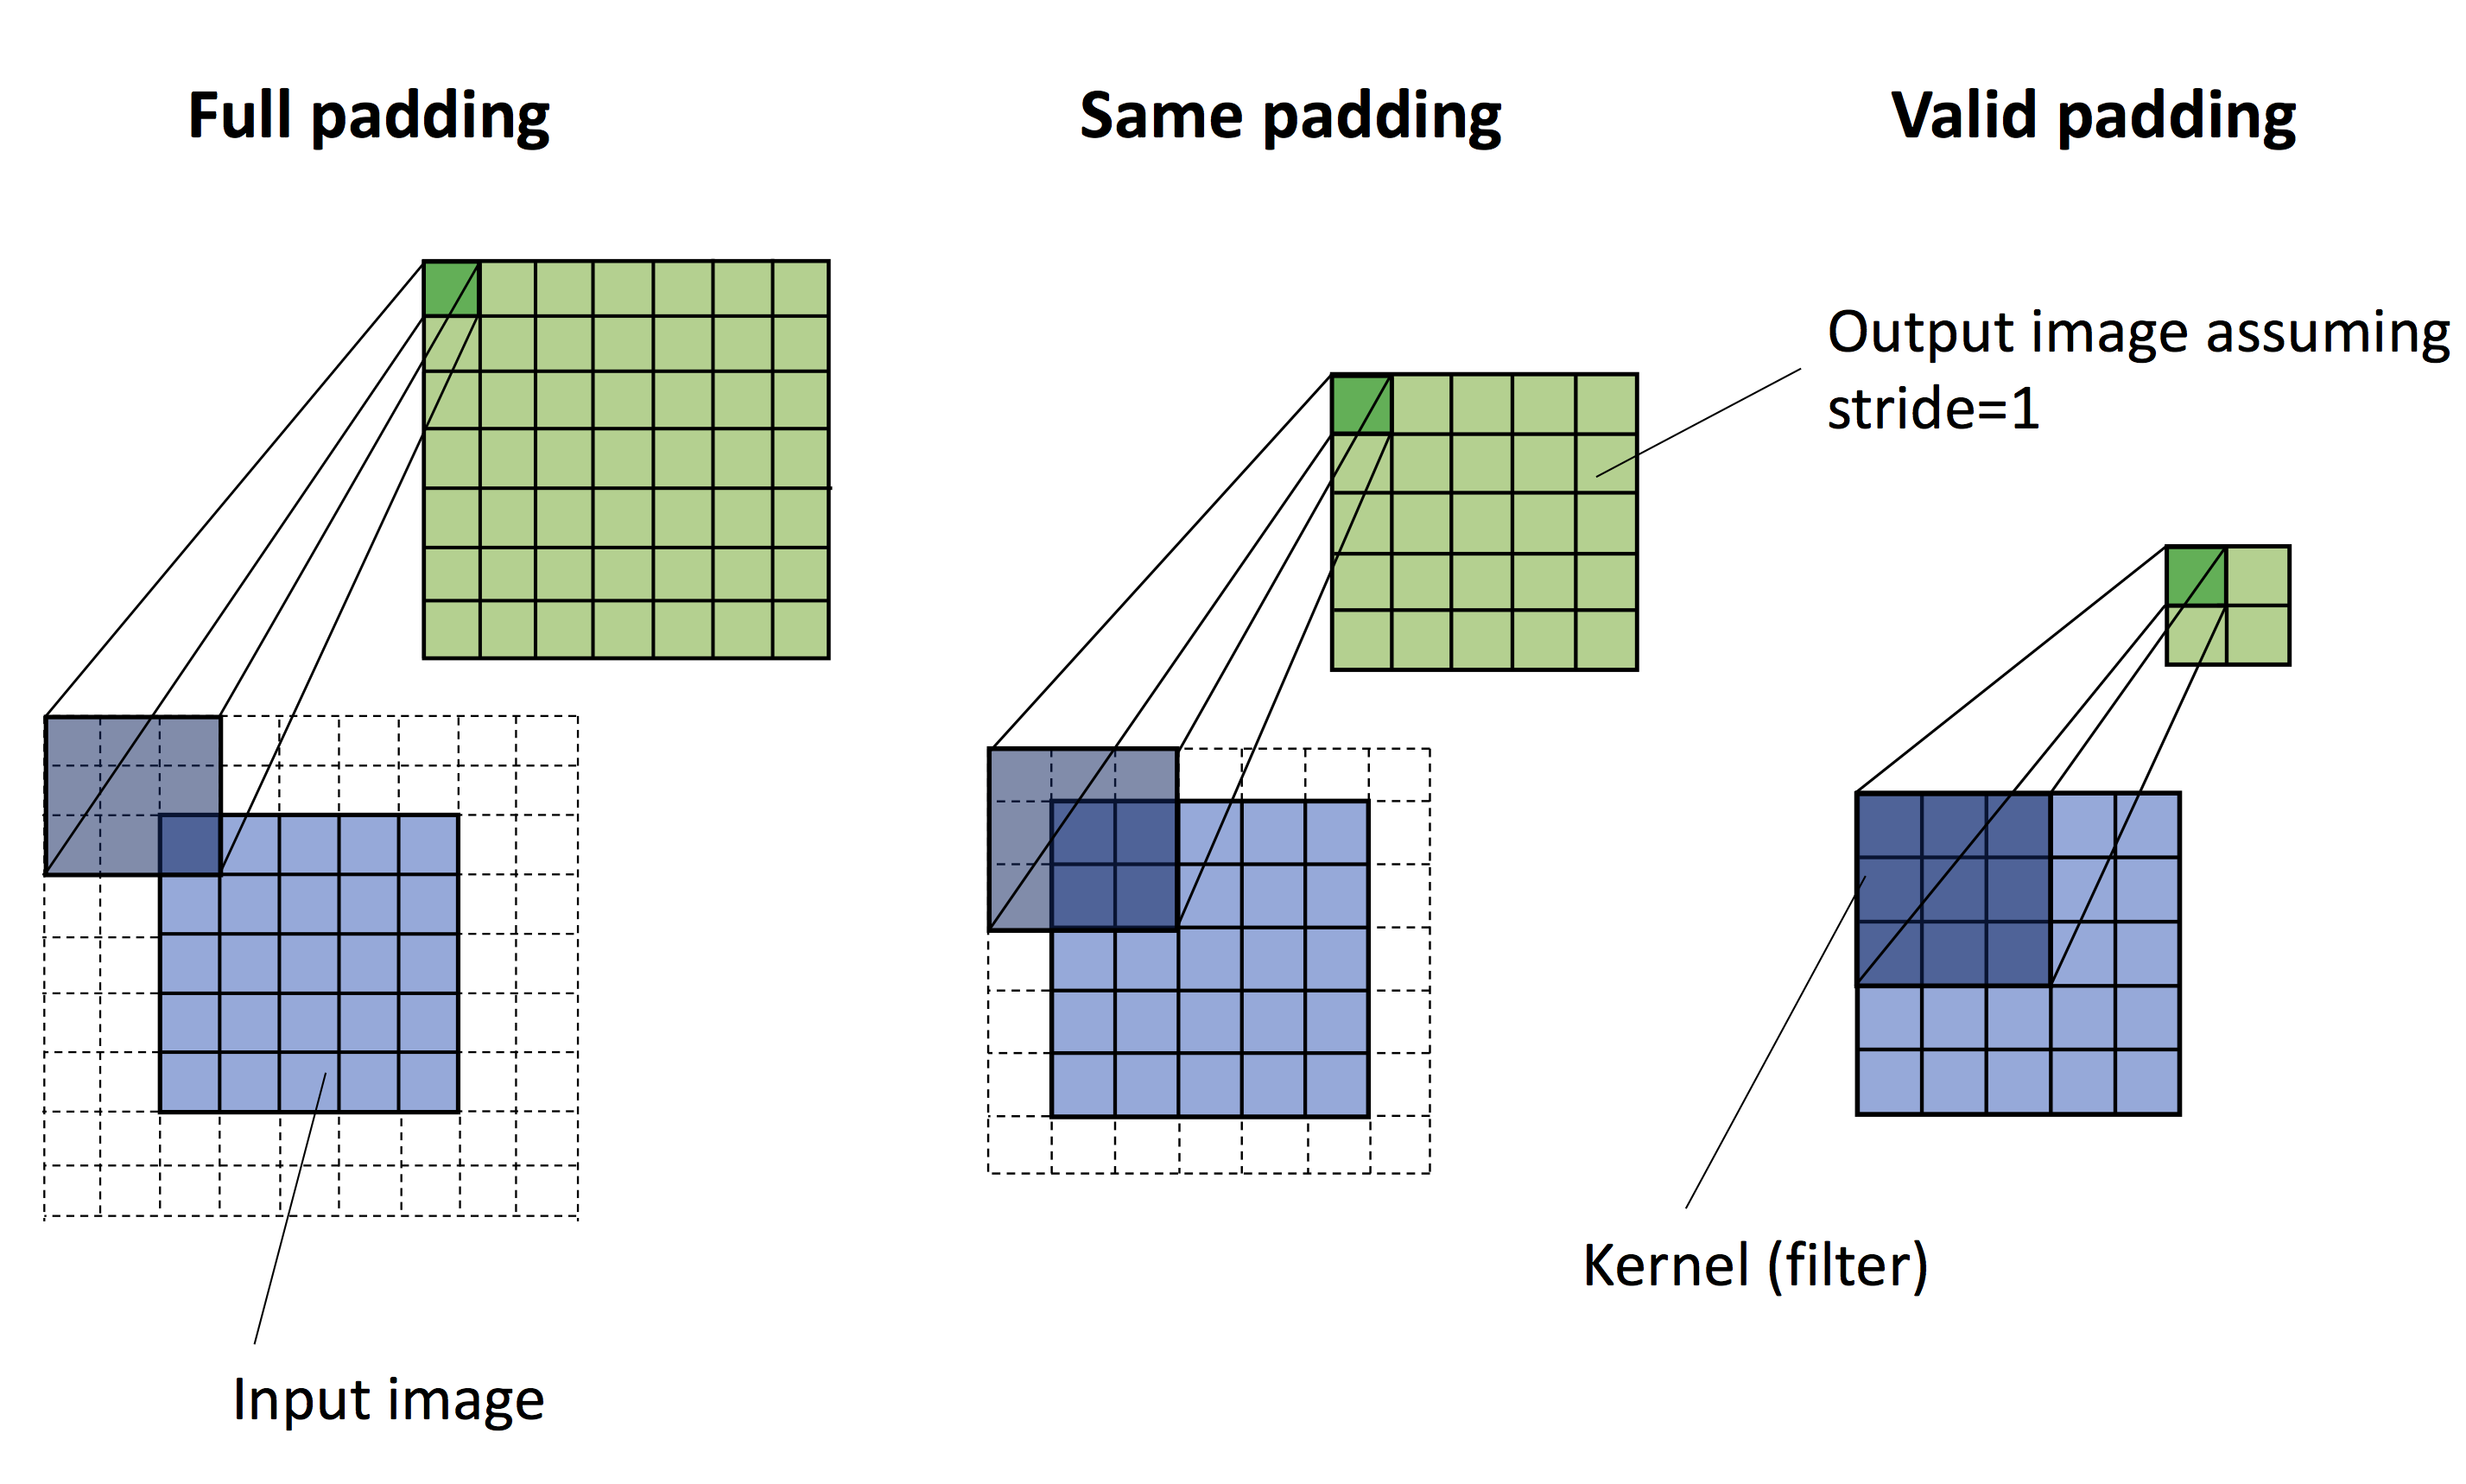

In [7]:
Image(filename='images/15_11.png', width=700) 

### Determining the size of the convolution output

In [8]:
import numpy as np


def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int(len(x)/s),s):
        res.append(np.sum(x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)

## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]
print('Conv1d Implementation: ', 
      conv1d(x, w, p=2, s=1))
print('Numpy Results:         ', 
      np.convolve(x, w, mode='same'))



Conv1d Implementation:  [  5.  14.  16.  26.  24.  34.  19.  22.]
Numpy Results:          [ 5 14 16 26 24 34 19 22]


### Performing a discrete convolution in 2D

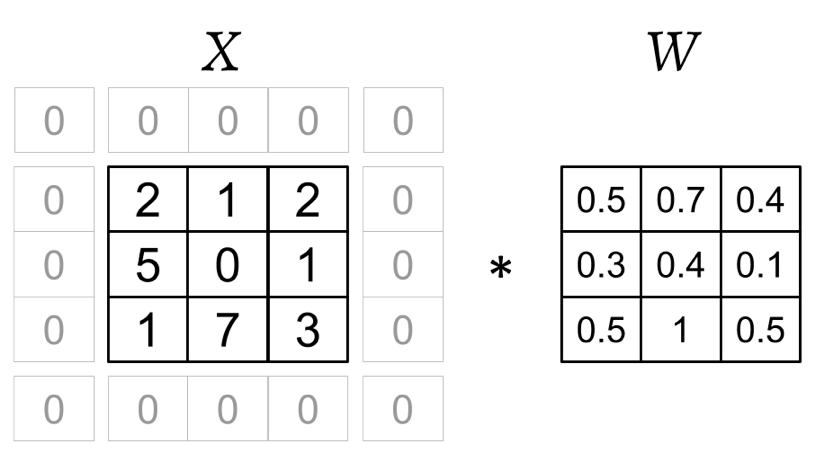

In [9]:
Image(filename='images/15_04.png', width=700) 

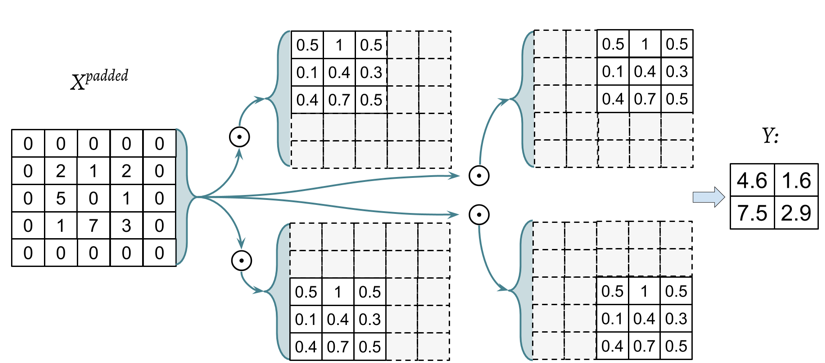

In [10]:
Image(filename='images/15_05.png', width=900) 

In [11]:
import numpy as np
import scipy.signal


def conv2d(X, W, p=(0,0), s=(1,1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1,n2))
    X_padded[p[0]:p[0] + X_orig.shape[0], 
             p[1]:p[1] + X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0], j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))
    
X = [[1, 3, 2, 4], [5, 6, 1, 3], [1 , 2,0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]
print('Conv2d Implementation: \n', 
      conv2d(X, W, p=(1,1), s=(1,1)))

print('Scipy Results:         \n', 
      scipy.signal.convolve2d(X, W, mode='same'))



Conv2d Implementation: 
 [[ 11.  25.  32.  13.]
 [ 19.  25.  24.  13.]
 [ 13.  28.  25.  17.]
 [ 11.  17.  14.   9.]]
Scipy Results:         
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


## Sub-sampling

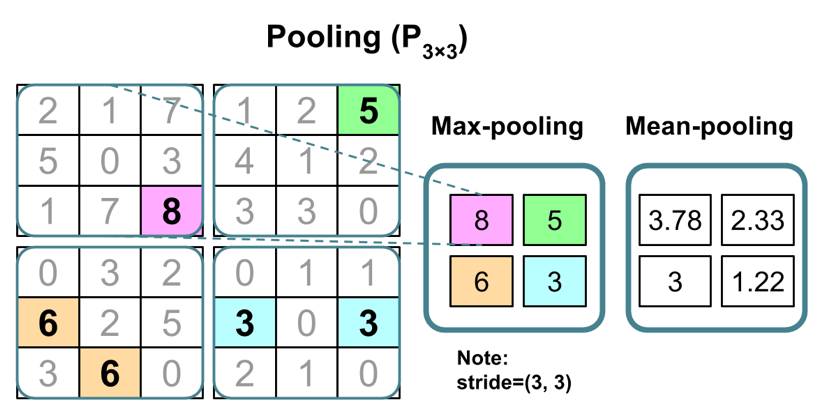

In [12]:
Image(filename='images/15_06.png', width=700) 

# Putting everything together to build a CNN 

## Working with multiple input or color channels

In [13]:
import scipy.misc


try:
    img = scipy.misc.imread('./example-image.png', mode='RGB')
except AttributeError:
    s = ("scipy.misc.imread requires Python's image library PIL"
         " You can satisfy this requirement by installing the"
         " userfriendly fork PILLOW via `pip install pillow`.")
    raise AttributeError(s)
    
    
print('Image shape:', img.shape)
print('Number of channels:', img.shape[2])
print('Image data type:', img.dtype)

print(img[100:102, 100:102, :])

Image shape: (252, 221, 3)
Number of channels: 3
Image data type: uint8
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]]


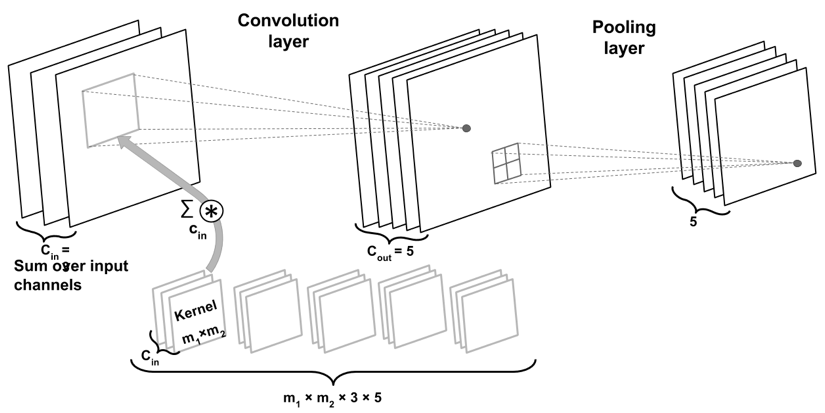

In [14]:
Image(filename='images/15_07.png', width=800) 

## Regularizing a neural network with dropout

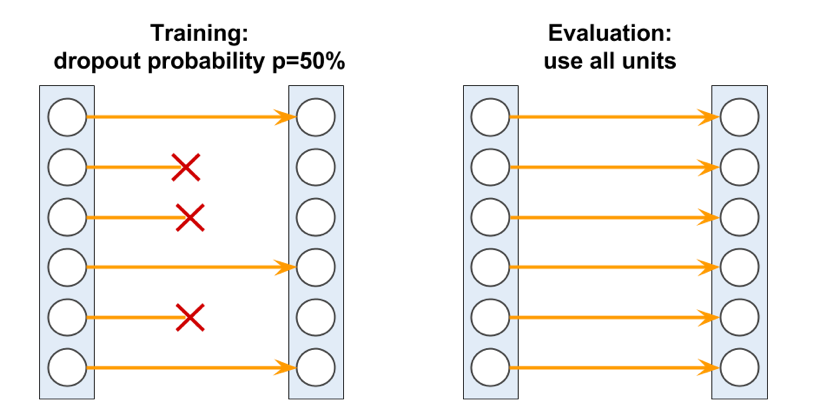

In [15]:
Image(filename='images/15_08.png', width=800) 

# Implementing a deep convolutional neural network using TensorFlow

## The multilayer CNN architecture 

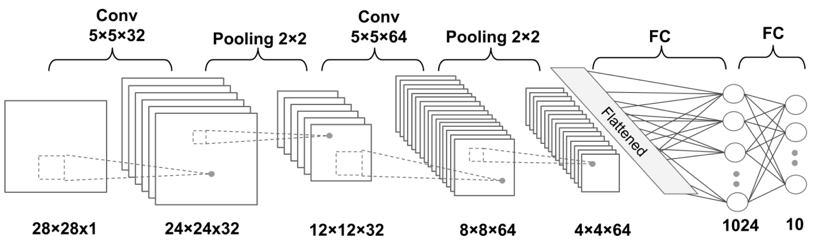

In [16]:
Image(filename='images/15_09.png', width=800) 

## Loading and preprocessing the data

In [17]:
## unzips mnist

import sys
import gzip
import shutil
import os


if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./')
                if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read())

In [18]:
import struct
import numpy as np


def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                                % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)

    return images, labels


X_data, y_data = load_mnist('./', kind='train')
print('Rows: %d,  Columns: %d' % (X_data.shape[0], X_data.shape[1]))
X_test, y_test = load_mnist('./', kind='t10k')
print('Rows: %d,  Columns: %d' % (X_test.shape[0], X_test.shape[1]))

X_train, y_train = X_data[:50000,:], y_data[:50000]
X_valid, y_valid = X_data[50000:,:], y_data[50000:]

print('Training:   ', X_train.shape, y_train.shape)
print('Validation: ', X_valid.shape, y_valid.shape)
print('Test Set:   ', X_test.shape, y_test.shape)

Rows: 60000,  Columns: 784
Rows: 10000,  Columns: 784
Training:    (50000, 784) (50000,)
Validation:  (10000, 784) (10000,)
Test Set:    (10000, 784) (10000,)


In [19]:
def batch_generator(X, y, batch_size=64, 
                    shuffle=False, random_seed=None):
    
    idx = np.arange(y.shape[0])
    
    if shuffle:
        rng = np.random.RandomState(random_seed)
        rng.shuffle(idx)
        X = X[idx]
        y = y[idx]
    
    for i in range(0, X.shape[0], batch_size):
        yield (X[i:i+batch_size, :], y[i:i+batch_size])

In [20]:
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals)/std_val
X_valid_centered = X_valid - mean_vals
X_test_centered = (X_test - mean_vals)/std_val

del X_data, y_data, X_train, X_valid, X_test

## Implementing a CNN in TensorFlow low-level API

In [21]:
import tensorflow as tf
import numpy as np


## wrapper functions 

def conv_layer(input_tensor, name,
               kernel_size, n_output_channels, 
               padding_mode='SAME', strides=(1, 1, 1, 1)):
    with tf.variable_scope(name):
        ## get n_input_channels:
        ##   input tensor shape: 
        ##   [batch x width x height x channels_in]
        input_shape = input_tensor.get_shape().as_list()
        n_input_channels = input_shape[-1] 

        weights_shape = (list(kernel_size) + 
                         [n_input_channels, n_output_channels])

        weights = tf.get_variable(name='_weights',
                                  shape=weights_shape)
        print(weights)
        biases = tf.get_variable(name='_biases',
                                 initializer=tf.zeros(
                                     shape=[n_output_channels]))
        print(biases)
        conv = tf.nn.conv2d(input=input_tensor, 
                            filter=weights,
                            strides=strides, 
                            padding=padding_mode)
        print(conv)
        conv = tf.nn.bias_add(conv, biases, 
                              name='net_pre-activation')
        print(conv)
        conv = tf.nn.relu(conv, name='activation')
        print(conv)
        
        return conv
    

## testing
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
    conv_layer(x, name='convtest', kernel_size=(3, 3), n_output_channels=32)
    
del g, x

<tf.Variable 'convtest/_weights:0' shape=(3, 3, 1, 32) dtype=float32_ref>
<tf.Variable 'convtest/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("convtest/Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("convtest/net_pre-activation:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("convtest/activation:0", shape=(?, 28, 28, 32), dtype=float32)


In [22]:
def fc_layer(input_tensor, name, 
             n_output_units, activation_fn=None):
    with tf.variable_scope(name):
        input_shape = input_tensor.get_shape().as_list()[1:]
        n_input_units = np.prod(input_shape)
        if len(input_shape) > 1:
            input_tensor = tf.reshape(input_tensor, 
                                      shape=(-1, n_input_units))

        weights_shape = [n_input_units, n_output_units]

        weights = tf.get_variable(name='_weights',
                                  shape=weights_shape)
        print(weights)
        biases = tf.get_variable(name='_biases',
                                 initializer=tf.zeros(
                                     shape=[n_output_units]))
        print(biases)
        layer = tf.matmul(input_tensor, weights)
        print(layer)
        layer = tf.nn.bias_add(layer, biases,
                              name='net_pre-activation')
        print(layer)
        if activation_fn is None:
            return layer
        
        layer = activation_fn(layer, name='activation')
        print(layer)
        return layer

    
## testing:
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, 
                       shape=[None, 28, 28, 1])
    fc_layer(x, name='fctest', n_output_units=32, 
             activation_fn=tf.nn.relu)
    
del g, x

<tf.Variable 'fctest/_weights:0' shape=(784, 32) dtype=float32_ref>
<tf.Variable 'fctest/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("fctest/MatMul:0", shape=(?, 32), dtype=float32)
Tensor("fctest/net_pre-activation:0", shape=(?, 32), dtype=float32)
Tensor("fctest/activation:0", shape=(?, 32), dtype=float32)


In [23]:
def build_cnn():
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, 784],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor: 
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, 28, 28, 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=10,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    h1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(5, 5), 
                    padding_mode='VALID',
                    n_output_channels=32)
    ## MaxPooling
    h1_pool = tf.nn.max_pool(h1, 
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1], 
                             padding='SAME')
    ## 2n layer: Conv_2
    print('\nBuilding 2nd layer: ')
    h2 = conv_layer(h1_pool, name='conv_2', 
                    kernel_size=(5,5), 
                    padding_mode='VALID',
                    n_output_channels=64)
    ## MaxPooling 
    h2_pool = tf.nn.max_pool(h2, 
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1], 
                             padding='SAME')

    ## 3rd layer: Fully Connected
    print('\nBuilding 3rd layer:')
    h3 = fc_layer(h2_pool, name='fc_3',
                  n_output_units=1024, 
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    h3_drop = tf.nn.dropout(h3, keep_prob=keep_prob, 
                            name='dropout_layer')

    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    h4 = fc_layer(h3_drop, name='fc_4',
                  n_output_units=10, 
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities' : tf.nn.softmax(h4, name='probabilities'),
        'labels' : tf.cast(tf.argmax(h4, axis=1), tf.int32,
                           name='labels')
    }
    
    ## Visualize the graph with TensorBoard:

    ## Loss Function and Optimization
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=h4, labels=tf_y_onehot),
        name='cross_entropy_loss')

    ## Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss,
                                   name='train_op')

    ## Computing the prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'], 
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')

    
def save(saver, sess, epoch, path='./model/'):
    if not os.path.isdir(path):
        os.makedirs(path)
    print('Saving model in %s' % path)
    saver.save(sess, os.path.join(path,'cnn-model.ckpt'),
               global_step=epoch)

    
def load(saver, sess, path, epoch):
    print('Loading model from %s' % path)
    saver.restore(sess, os.path.join(
            path, 'cnn-model.ckpt-%d' % epoch))

    
def train(sess, training_set, validation_set=None,
          initialize=True, epochs=20, shuffle=True,
          dropout=0.5, random_seed=None):

    X_data = np.array(training_set[0])
    y_data = np.array(training_set[1])
    training_loss = []

    ## initialize variables
    if initialize:
        sess.run(tf.global_variables_initializer())

    np.random.seed(random_seed) # for shuflling in batch_generator
    for epoch in range(1, epochs+1):
        batch_gen = batch_generator(
                        X_data, y_data, 
                        shuffle=shuffle)
        avg_loss = 0.0
        for i,(batch_x,batch_y) in enumerate(batch_gen):
            feed = {'tf_x:0': batch_x, 
                    'tf_y:0': batch_y, 
                    'fc_keep_prob:0': dropout}
            loss, _ = sess.run(
                    ['cross_entropy_loss:0', 'train_op'],
                    feed_dict=feed)
            avg_loss += loss

        training_loss.append(avg_loss / (i+1))
        print('Epoch %02d Training Avg. Loss: %7.3f' % (
            epoch, avg_loss), end=' ')
        if validation_set is not None:
            feed = {'tf_x:0': validation_set[0],
                    'tf_y:0': validation_set[1],
                    'fc_keep_prob:0':1.0}
            valid_acc = sess.run('accuracy:0', feed_dict=feed)
            print(' Validation Acc: %7.3f' % valid_acc)
        else:
            print()

            
def predict(sess, X_test, return_proba=False):
    feed = {'tf_x:0': X_test, 
            'fc_keep_prob:0': 1.0}
    if return_proba:
        return sess.run('probabilities:0', feed_dict=feed)
    else:
        return sess.run('labels:0', feed_dict=feed)

In [24]:
import tensorflow as tf
import numpy as np

## Define hyperparameters
learning_rate = 1e-4
random_seed = 123

np.random.seed(random_seed)


## create a graph
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    ## build the graph
    build_cnn()

    ## saver:
    saver = tf.train.Saver()


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 24, 24, 32), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 8, 8, 64), dtype=float32)

Building 3rd layer:
<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32_ref>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc_3/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(?, 1024), dtype=float32

In [25]:
## @Readers: PLEASE IGNORE THIS CELL
##
## This cell is meant to shrink the
## dataset when this notebook is run 
## on the Travis Continuous Integration
## platform to test the code as well as
## speeding up the run using a smaller
## dataset for debugging

if 'TRAVIS' in os.environ:
    X_train_centered = X_train_centered[:500]
    y_train = y_train[:500]
    X_valid_centered = X_valid_centered[:500]
    y_valid = y_valid[:500]

In [26]:
## crearte a TF session 
## and train the CNN model

with tf.Session(graph=g) as sess:
    train(sess, 
          training_set=(X_train_centered, y_train), 
          validation_set=(X_valid_centered, y_valid), 
          initialize=True,
          random_seed=123)
    save(saver, sess, epoch=20)

Epoch 01 Training Avg. Loss: 274.884  Validation Acc:   0.973
Epoch 02 Training Avg. Loss:  76.537  Validation Acc:   0.981
Epoch 03 Training Avg. Loss:  51.816  Validation Acc:   0.984
Epoch 04 Training Avg. Loss:  38.888  Validation Acc:   0.986
Epoch 05 Training Avg. Loss:  33.064  Validation Acc:   0.987
Epoch 06 Training Avg. Loss:  27.396  Validation Acc:   0.990
Epoch 07 Training Avg. Loss:  23.094  Validation Acc:   0.987
Epoch 08 Training Avg. Loss:  20.075  Validation Acc:   0.989
Epoch 09 Training Avg. Loss:  16.844  Validation Acc:   0.991
Epoch 10 Training Avg. Loss:  15.895  Validation Acc:   0.990
Epoch 11 Training Avg. Loss:  13.291  Validation Acc:   0.989
Epoch 12 Training Avg. Loss:  10.677  Validation Acc:   0.991
Epoch 13 Training Avg. Loss:  10.241  Validation Acc:   0.992
Epoch 14 Training Avg. Loss:   9.578  Validation Acc:   0.990
Epoch 15 Training Avg. Loss:   7.571  Validation Acc:   0.992
Epoch 16 Training Avg. Loss:   6.860  Validation Acc:   0.991
Epoch 17

In [27]:
### Calculate prediction accuracy
### on test set
### restoring the saved model

del g

## create a new graph 
## and build the model
g2 = tf.Graph()
with g2.as_default():
    tf.set_random_seed(random_seed)
    ## build the graph
    build_cnn()

    ## saver:
    saver = tf.train.Saver()

## create a new session 
## and restore the model
with tf.Session(graph=g2) as sess:
    load(saver, sess, 
         epoch=20, path='./model/')
    
    preds = predict(sess, X_test_centered, 
                    return_proba=False)

    print('Test Accuracy: %.3f%%' % (100*
                np.sum(preds == y_test)/len(y_test)))
    


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 24, 24, 32), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 8, 8, 64), dtype=float32)

Building 3rd layer:
<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32_ref>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc_3/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(?, 1024), dtype=float32

In [28]:
## run the prediction on 
##  some test samples

np.set_printoptions(precision=2, suppress=True)

with tf.Session(graph=g2) as sess:
    load(saver, sess, 
         epoch=20, path='./model/')
        
    print(predict(sess, X_test_centered[:10], 
              return_proba=False))
    
    print(predict(sess, X_test_centered[:10], 
                  return_proba=True))

Loading model from ./model/
INFO:tensorflow:Restoring parameters from ./model/cnn-model.ckpt-20
[7 2 1 0 4 1 4 9 5 9]
[[ 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0.    0.    0.    0.99  0.01  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]]


In [29]:
## continue training for 20 more epochs
## without re-initializing :: initialize=False
## create a new session 
## and restore the model
with tf.Session(graph=g2) as sess:
    load(saver, sess, 
         epoch=20, path='./model/')
    
    train(sess,
          training_set=(X_train_centered, y_train), 
          validation_set=(X_valid_centered, y_valid),
          initialize=False,
          epochs=20,
          random_seed=123)
        
    save(saver, sess, epoch=40, path='./model/')
    
    preds = predict(sess, X_test_centered, 
                    return_proba=False)
    
    print('Test Accuracy: %.3f%%' % (100*
                np.sum(preds == y_test)/len(y_test)))

Loading model from ./model/
INFO:tensorflow:Restoring parameters from ./model/cnn-model.ckpt-20
Epoch 01 Training Avg. Loss:   4.145  Validation Acc:   0.990
Epoch 02 Training Avg. Loss:   3.778  Validation Acc:   0.992
Epoch 03 Training Avg. Loss:   4.253  Validation Acc:   0.990
Epoch 04 Training Avg. Loss:   3.245  Validation Acc:   0.992
Epoch 05 Training Avg. Loss:   3.094  Validation Acc:   0.991
Epoch 06 Training Avg. Loss:   2.686  Validation Acc:   0.992
Epoch 07 Training Avg. Loss:   3.045  Validation Acc:   0.992
Epoch 08 Training Avg. Loss:   2.288  Validation Acc:   0.992
Epoch 09 Training Avg. Loss:   2.243  Validation Acc:   0.991
Epoch 10 Training Avg. Loss:   1.813  Validation Acc:   0.992
Epoch 11 Training Avg. Loss:   2.726  Validation Acc:   0.992
Epoch 12 Training Avg. Loss:   2.200  Validation Acc:   0.992
Epoch 13 Training Avg. Loss:   2.190  Validation Acc:   0.992
Epoch 14 Training Avg. Loss:   1.639  Validation Acc:   0.991
Epoch 15 Training Avg. Loss:   1.910

In [30]:
## build the model
def build_cnn():
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, 784],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor: 
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, 28, 28, 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=10,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    h1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(5, 5), 
                    padding_mode='VALID',
                    n_output_channels=32)
    ## MaxPooling
    h1_pool = tf.nn.max_pool(h1, 
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1], 
                             padding='SAME')
    ## 2n layer: Conv_2
    print('\nBuilding 2nd layer: ')
    h2 = conv_layer(h1_pool, name='conv_2', 
                    kernel_size=(5, 5), 
                    padding_mode='VALID',
                    n_output_channels=64)
    ## MaxPooling 
    h2_pool = tf.nn.max_pool(h2, 
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1], 
                             padding='SAME')

    ## 3rd layer: Fully Connected
    print('\nBuilding 3rd layer:')
    h3 = fc_layer(h2_pool, name='fc_3',
                  n_output_units=1024, 
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    h3_drop = tf.nn.dropout(h3, keep_prob=keep_prob, 
                            name='dropout_layer')

    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    h4 = fc_layer(h3_drop, name='fc_4',
                  n_output_units=10, 
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities': tf.nn.softmax(h4, name='probabilities'),
        'labels': tf.cast(tf.argmax(h4, axis=1), tf.int32,
                           name='labels')
    }

## create a graph
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    ## build the graph
    build_cnn()
    

with tf.Session(graph=g) as sess:
    file_writer = tf.summary.FileWriter(logdir='./tensorboard/', graph=g)


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 24, 24, 32), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 8, 8, 64), dtype=float32)

Building 3rd layer:
<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32_ref>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc_3/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(?, 1024), dtype=float32

#### Visualize the graph with TensorBoard

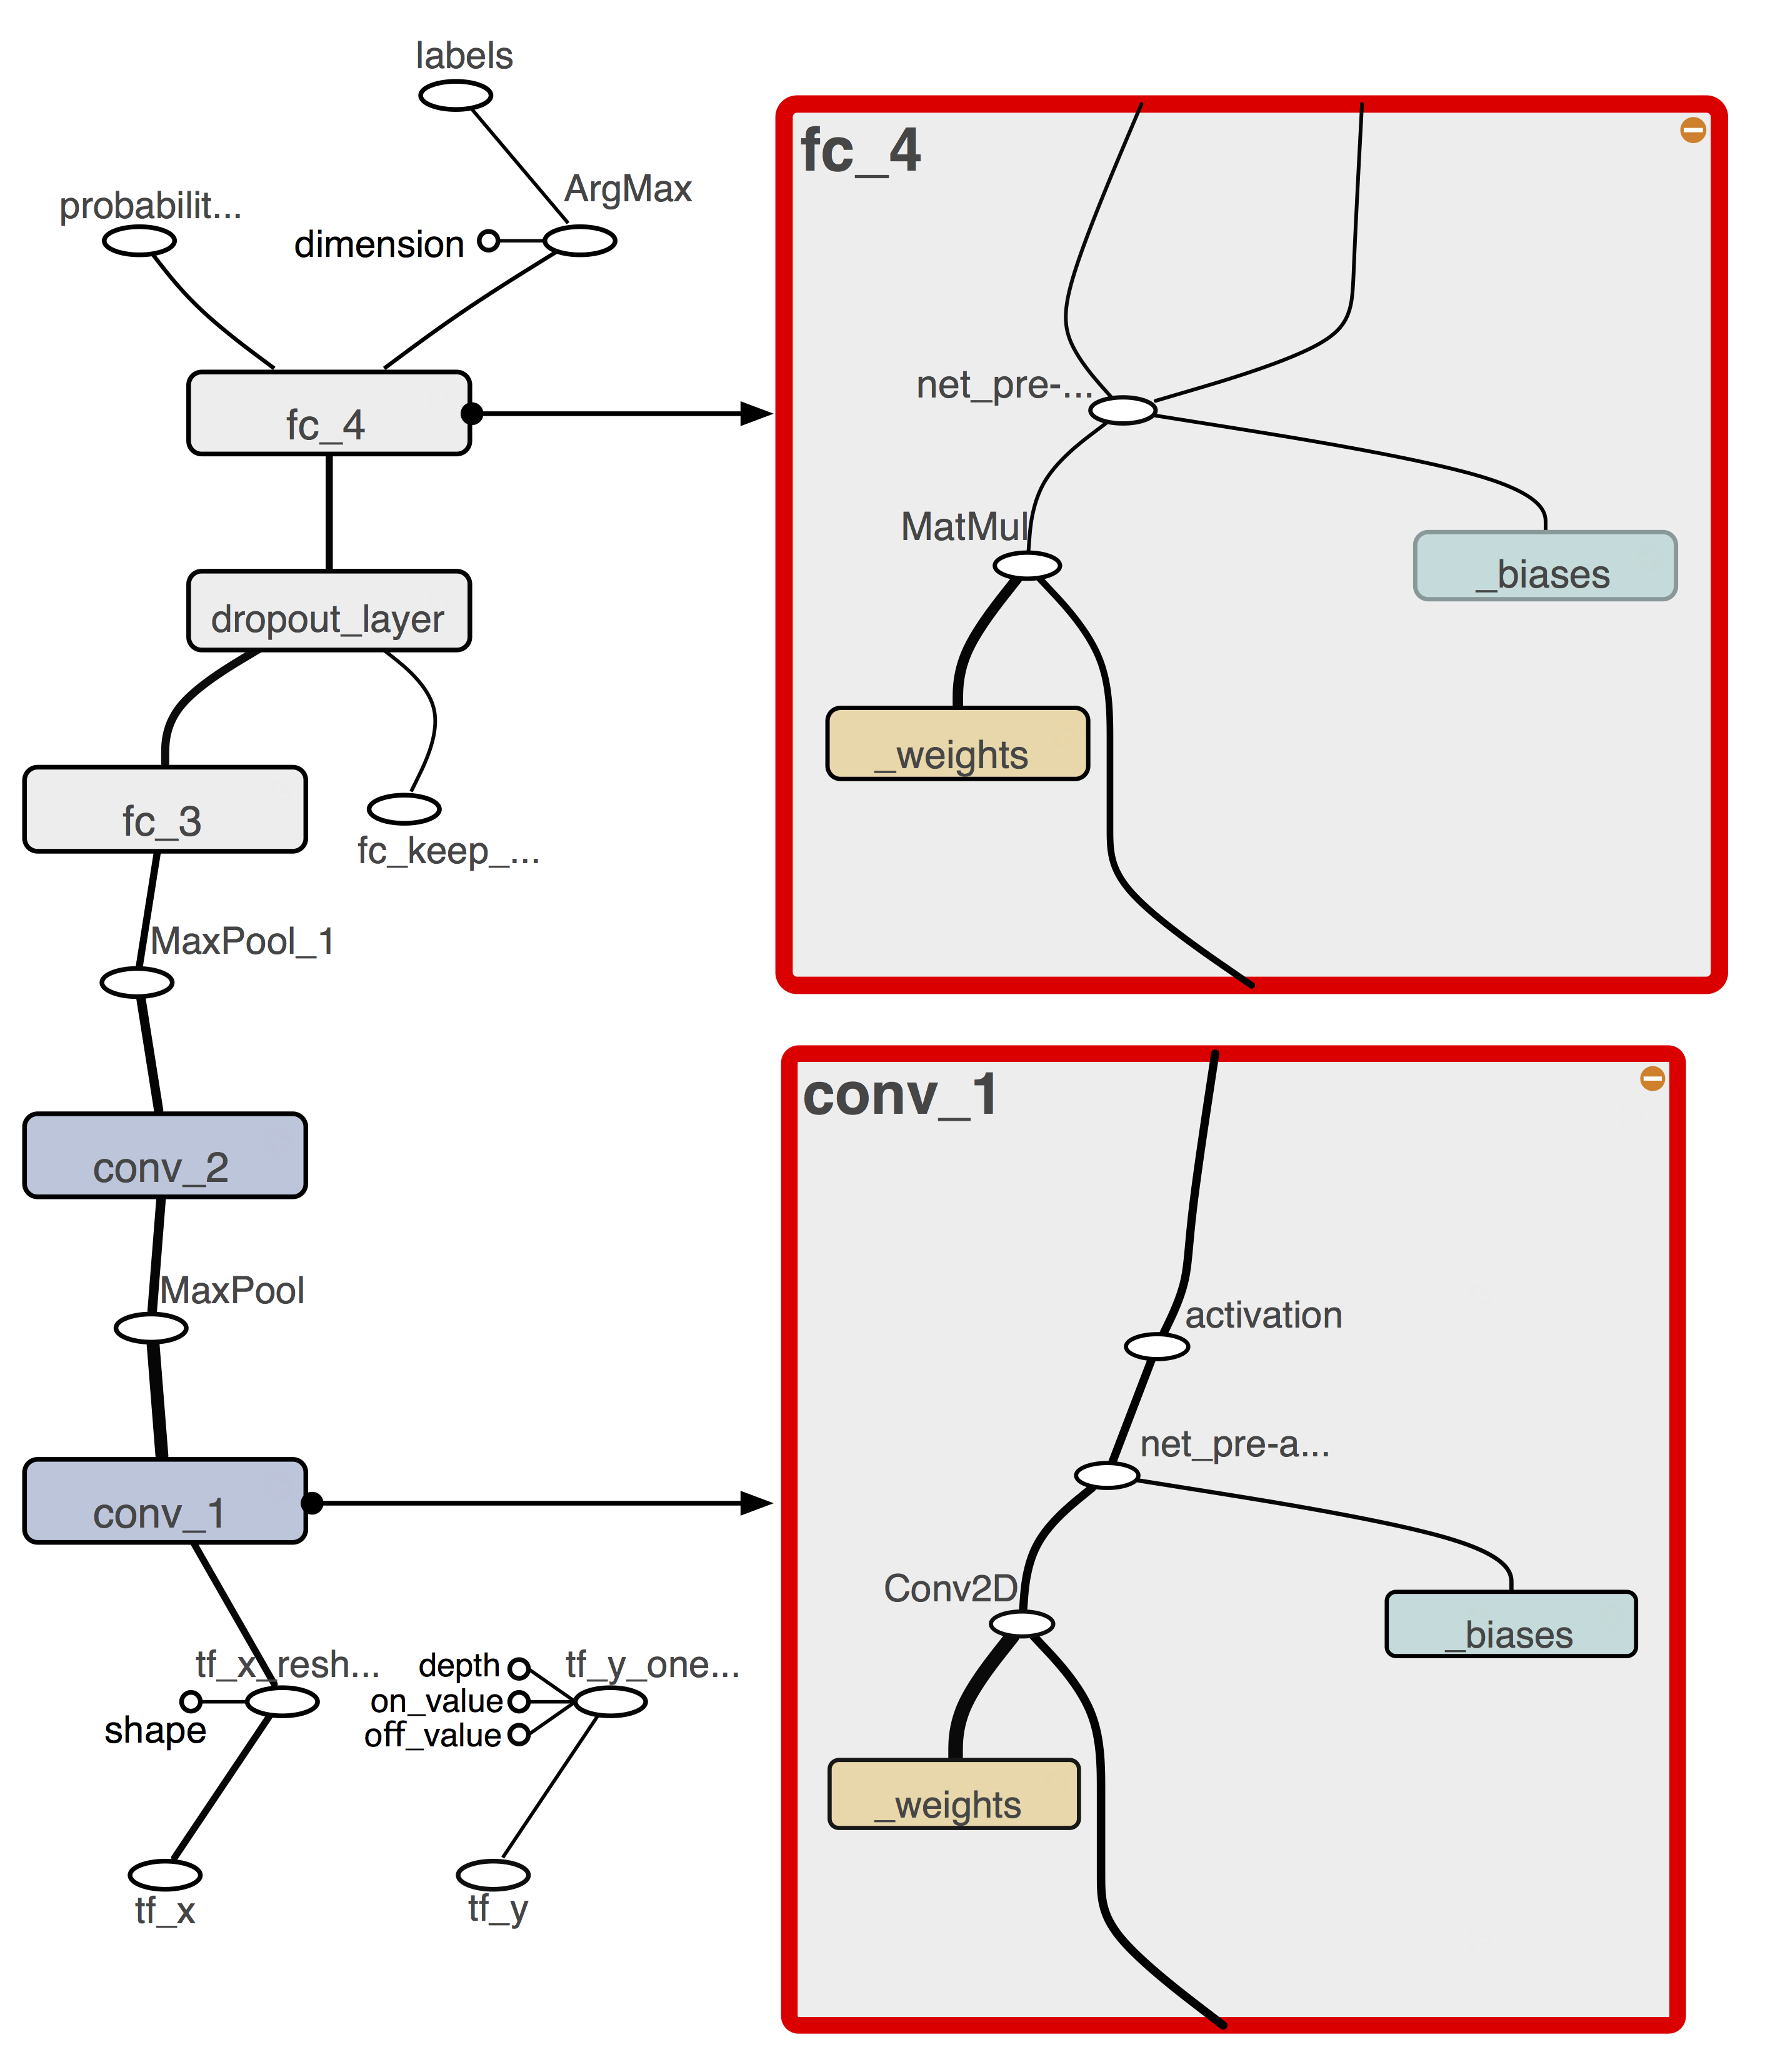

In [4]:
Image(filename='images/15_10.png', width=800) 

## Implementing a CNN in the TensorFlow layers API

In [32]:
import tensorflow as tf
import numpy as np


class ConvNN(object):
    def __init__(self, batchsize=64,
                 epochs=20, learning_rate=1e-4, 
                 dropout_rate=0.5,
                 shuffle=True, random_seed=None):
        np.random.seed(random_seed)
        self.batchsize = batchsize
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.shuffle = shuffle
                
        g = tf.Graph()
        with g.as_default():
            ## set random-seed:
            tf.set_random_seed(random_seed)
            
            ## build the network:
            self.build()

            ## initializer
            self.init_op = \
                tf.global_variables_initializer()

            ## saver
            self.saver = tf.train.Saver()
            
        ## create a session
        self.sess = tf.Session(graph=g)
                
    def build(self):
        
        ## Placeholders for X and y:
        tf_x = tf.placeholder(tf.float32, 
                              shape=[None, 784],
                              name='tf_x')
        tf_y = tf.placeholder(tf.int32, 
                              shape=[None],
                              name='tf_y')
        is_train = tf.placeholder(tf.bool, 
                              shape=(),
                              name='is_train')

        ## reshape x to a 4D tensor: 
        ##  [batchsize, width, height, 1]
        tf_x_image = tf.reshape(tf_x, shape=[-1, 28, 28, 1],
                              name='input_x_2dimages')
        ## One-hot encoding:
        tf_y_onehot = tf.one_hot(indices=tf_y, depth=10,
                              dtype=tf.float32,
                              name='input_y_onehot')

        ## 1st layer: Conv_1
        h1 = tf.layers.conv2d(tf_x_image, 
                              kernel_size=(5, 5), 
                              filters=32, 
                              activation=tf.nn.relu)
        ## MaxPooling
        h1_pool = tf.layers.max_pooling2d(h1, 
                              pool_size=(2, 2), 
                              strides=(2, 2))
        ## 2n layer: Conv_2
        h2 = tf.layers.conv2d(h1_pool, kernel_size=(5,5), 
                              filters=64, 
                              activation=tf.nn.relu)
        ## MaxPooling 
        h2_pool = tf.layers.max_pooling2d(h2, 
                              pool_size=(2, 2), 
                              strides=(2, 2))

        ## 3rd layer: Fully Connected
        input_shape = h2_pool.get_shape().as_list()
        n_input_units = np.prod(input_shape[1:])
        h2_pool_flat = tf.reshape(h2_pool, 
                              shape=[-1, n_input_units])
        h3 = tf.layers.dense(h2_pool_flat, 1024, 
                              activation=tf.nn.relu)

        ## Dropout
        h3_drop = tf.layers.dropout(h3, 
                              rate=self.dropout_rate,
                              training=is_train)
        
        ## 4th layer: Fully Connected (linear activation)
        h4 = tf.layers.dense(h3_drop, 10, 
                              activation=None)

        ## Prediction
        predictions = {
            'probabilities': tf.nn.softmax(h4, 
                              name='probabilities'),
            'labels': tf.cast(tf.argmax(h4, axis=1), 
                              tf.int32, name='labels')}
        
        ## Loss Function and Optimization
        cross_entropy_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=h4, labels=tf_y_onehot),
            name='cross_entropy_loss')
        
        ## Optimizer:
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        optimizer = optimizer.minimize(cross_entropy_loss,
                              name='train_op')

        ## Finding accuracy
        correct_predictions = tf.equal(
            predictions['labels'], 
            tf_y, name='correct_preds')
        
        accuracy = tf.reduce_mean(
            tf.cast(correct_predictions, tf.float32),
            name='accuracy')

    def save(self, epoch, path='./tflayers-model/'):
        if not os.path.isdir(path):
            os.makedirs(path)
        print('Saving model in %s' % path)
        self.saver.save(self.sess, 
                        os.path.join(path, 'model.ckpt'),
                        global_step=epoch)
        
    def load(self, epoch, path):
        print('Loading model from %s' % path)
        self.saver.restore(self.sess, 
             os.path.join(path, 'model.ckpt-%d' % epoch))
        
    def train(self, training_set, 
              validation_set=None,
              initialize=True):
        ## initialize variables
        if initialize:
            self.sess.run(self.init_op)

        self.train_cost_ = []
        X_data = np.array(training_set[0])
        y_data = np.array(training_set[1])

        for epoch in range(1, self.epochs + 1):
            batch_gen = \
                batch_generator(X_data, y_data, 
                                 shuffle=self.shuffle)
            avg_loss = 0.0
            for i, (batch_x,batch_y) in \
                enumerate(batch_gen):
                feed = {'tf_x:0': batch_x, 
                        'tf_y:0': batch_y,
                        'is_train:0': True} ## for dropout
                loss, _ = self.sess.run(
                        ['cross_entropy_loss:0', 'train_op'], 
                        feed_dict=feed)
                avg_loss += loss
                
            print('Epoch %02d: Training Avg. Loss: '
                  '%7.3f' % (epoch, avg_loss), end=' ')
            if validation_set is not None:
                feed = {'tf_x:0': batch_x, 
                        'tf_y:0': batch_y,
                        'is_train:0': False} ## for dropout
                valid_acc = self.sess.run('accuracy:0',
                                          feed_dict=feed)
                print('Validation Acc: %7.3f' % valid_acc)
            else:
                print()
                    
    def predict(self, X_test, return_proba = False):
        feed = {'tf_x:0': X_test,
                'is_train:0': False} ## for dropout
        if return_proba:
            return self.sess.run('probabilities:0',
                                 feed_dict=feed)
        else:
            return self.sess.run('labels:0',
                                 feed_dict=feed)




In [33]:
cnn = ConvNN(random_seed=123)

In [34]:
cnn.train(training_set=(X_train_centered, y_train), 
          validation_set=(X_valid_centered, y_valid))

cnn.save(epoch=20)

Epoch 01: Training Avg. Loss: 262.962 Validation Acc:   1.000
Epoch 02: Training Avg. Loss:  73.309 Validation Acc:   1.000
Epoch 03: Training Avg. Loss:  50.763 Validation Acc:   1.000
Epoch 04: Training Avg. Loss:  39.567 Validation Acc:   1.000
Epoch 05: Training Avg. Loss:  32.161 Validation Acc:   1.000
Epoch 06: Training Avg. Loss:  26.815 Validation Acc:   0.938
Epoch 07: Training Avg. Loss:  23.939 Validation Acc:   0.938
Epoch 08: Training Avg. Loss:  19.429 Validation Acc:   1.000
Epoch 09: Training Avg. Loss:  17.655 Validation Acc:   1.000
Epoch 10: Training Avg. Loss:  14.999 Validation Acc:   1.000
Epoch 11: Training Avg. Loss:  13.101 Validation Acc:   1.000
Epoch 12: Training Avg. Loss:  11.254 Validation Acc:   1.000
Epoch 13: Training Avg. Loss:   9.751 Validation Acc:   1.000
Epoch 14: Training Avg. Loss:   9.099 Validation Acc:   1.000
Epoch 15: Training Avg. Loss:   8.616 Validation Acc:   1.000
Epoch 16: Training Avg. Loss:   7.116 Validation Acc:   1.000
Epoch 17

In [35]:
del cnn

cnn2 = ConvNN(random_seed=123)

cnn2.load(epoch=20, path='./tflayers-model/')

print(cnn2.predict(X_test_centered[:10,:]))

Loading model from ./tflayers-model/
INFO:tensorflow:Restoring parameters from ./tflayers-model/model.ckpt-20
[7 2 1 0 4 1 4 9 5 9]


In [36]:
preds = cnn2.predict(X_test_centered)

print('Test Accuracy: %.2f%%' % (100*
      np.sum(y_test == preds)/len(y_test)))

Test Accuracy: 99.37%


# Summary

...

---

Readers may ignore the next cell.

In [2]:
! python ../.convert_notebook_to_script.py --input ch15.ipynb --output ch15.py

[NbConvertApp] Converting notebook ch15.ipynb to script
[NbConvertApp] Writing 28884 bytes to ch15.py
